## Imports 

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score 


if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()

In [3]:
os.chdir(root)
from data_treatment.box_creator import create_binary_box

df = pd.read_csv('database.csv')
df = create_binary_box(df, threshold=2., box_length=7).set_index("Date").dropna(axis = 0)

## Our model 

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

prescale_X = df.drop(columns="Box")
y = df["Box"]
x = (prescale_X - prescale_X.mean())/prescale_X.std()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
ridge = LogisticRegression(penalty="l2", solver="newton-cg", C = 0.3)
ridge.fit(X_train, y_train)

score= ridge.score(X_train, y_train)
score

0.7896640826873385

### Confusion Matrix

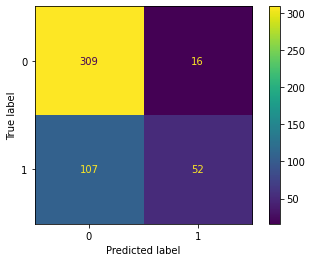

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(ridge, X_test, y_test)


## Getting our precision, recall and f-1 scores

In [72]:
y_pred= ridge.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       325
           1       0.76      0.33      0.46       159

    accuracy                           0.75       484
   macro avg       0.75      0.64      0.65       484
weighted avg       0.75      0.75      0.71       484



### The ROC Curve (receiver operating characteristic)\
plots the true positive rate against the false positive rate \
ie plots sensitivity versus 1- specificity 

In [73]:
y_scores= ridge.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

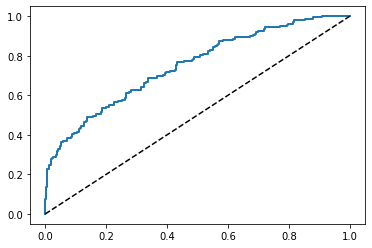

In [74]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label= label)
    plt.plot([0,1], [0,1], 'k--') 
    return 

plot_roc_curve(fpr, tpr)
plt.show()

### Area under the curve 

In [75]:
roc_auc_score(y_test, y_scores)

0.7477116594097726

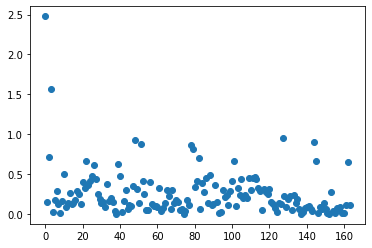

In [76]:
plt.scatter(x=range(0,X_test.shape[1]), y=abs(ridge.coef_))

In [77]:
import statsmodels.api as sm

log_reg = sm.Logit(y_train, sm.add_constant(X_train))

p_val = log_reg.fit_regularized(L1_wt=0.).pvalues

Iteration limit reached    (Exit mode 9)
            Current function value: 0.3960911422462724
            Iterations: 1000
            Function evaluations: 1002
            Gradient evaluations: 1000


/Users/g0bel1n/PycharmProjects/pythonProject/basic_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [78]:
X_train.loc[:,(p_val.iloc[1:]<=0.2).values]

,PX_OPEN_VIX_volatility,PX_LOW_VIX_volatility,PX_LAST_VIX_volatility,PUT_CALL_VOLUME_RATIO_CUR_DAY_VIX_volatility,VOLATILITY_30D_VIX_volatility,VOLATILITY_360D_VIX_volatility,VOLATILITY_180D_VIX_volatility,HIST_CALL_IMP_VOL_VIX_volatility,3MTH_IMPVOL_100.0%MNY_DF_VIX_volatility,3MTH_IMPVOL_105.0%MNY_DF_VIX_volatility,...,USD SWAP SEMI 30/360 10Y_USD SWAP SEMI 30 360 10Y,US Generic Govt 3 Mth_US Generic Govt 3 Mth,PX_LAST_Euribor3,PX_LAST_Bund10,S&P 500 Weeky High_SENTIMENT,S&P 500 Weekly Close_SENTIMENT,ST_Rev_F-F_ST_Reversal_Factor_daily,CMA_F-F_Research_Data_5_Factors_2x3_daily,RF_F-F_Research_Data_5_Factors_2x3_daily,Mom _F-F_Momentum_Factor_daily
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-22,-0.057121,0.029770,0.141239,0.141980,-0.622180,1.072996,-0.047666,0.766447,1.357566,1.374061,...,-0.865902,-0.875885,-0.730301,-0.859133,2.553565,2.613130,0.527253,-0.539712,-0.862774,-0.131060
2016-03-29,-0.253715,-0.419935,-0.487777,-0.320073,-0.683281,0.609263,0.943187,-0.274598,-0.033208,-0.019102,...,-0.770655,-0.754484,-0.563171,-0.629250,-0.284567,-0.282098,0.183563,-1.277102,-0.717101,-0.140215
2019-07-23,-0.549883,-0.594196,-0.643423,-0.313962,-1.019117,0.135475,-0.405159,-0.503350,-0.667751,-0.676110,...,-0.536270,0.303211,-0.636888,-0.920002,1.005969,1.008682,0.068999,1.023555,0.448279,-0.707836
2019-08-02,-0.004781,0.036796,-0.000257,-0.389953,-0.512154,0.121279,-0.465085,0.079198,-0.074337,-0.096508,...,-0.706319,0.307343,-0.640828,-1.002737,1.019637,1.003179,0.110659,0.581121,0.156934,0.207681
2006-09-19,-0.736264,-0.691163,-0.724462,0.547785,-1.281676,-1.725372,-1.138741,0.236496,-1.272361,-1.458880,...,1.746169,1.988805,1.457588,1.523615,-1.276234,-1.263322,-0.462159,0.699103,2.050676,0.244302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-22,-0.999240,-1.022821,-1.031895,-0.546947,0.616228,-0.033693,-0.336450,-0.069168,0.305656,0.382529,...,-0.391830,-0.290993,-0.612128,-0.446053,0.322637,0.360125,-0.368426,0.935068,-0.134411,-0.314164
2014-08-11,-0.327757,-0.429772,-0.435038,-0.581574,0.758355,-0.873026,-0.906268,-0.002180,-0.116319,-0.070804,...,-0.134977,-0.870007,-0.313319,-0.084386,-0.380901,-0.440730,-0.170543,-0.746181,-0.862774,0.006267
2006-05-15,-0.332863,-0.469122,-0.519935,-0.762227,-1.107006,-2.559973,-2.358452,-0.796113,-1.127039,-1.200829,...,2.017257,1.907968,1.195919,1.664263,-1.264553,-1.254374,0.204392,0.050200,2.050676,-1.531801


In [79]:
X_train

,PX_OPEN_VIX_volatility,PX_HIGH_VIX_volatility,PX_LOW_VIX_volatility,PX_LAST_VIX_volatility,VOLUME_TOTAL_CALL_VIX_volatility,PUT_CALL_VOLUME_RATIO_CUR_DAY_VIX_volatility,VOLUME_TOTAL_PUT_VIX_volatility,TOT_OPT_VOLUME_CUR_DAY_VIX_volatility,OPEN_INT_TOTAL_CALL_VIX_volatility,OPEN_INT_TOTAL_PUT_VIX_volatility,...,S&P 500 Weekly Low_SENTIMENT,S&P 500 Weekly Close_SENTIMENT,ST_Rev_F-F_ST_Reversal_Factor_daily,Mkt-RF_F-F_Research_Data_5_Factors_2x3_daily,SMB_F-F_Research_Data_5_Factors_2x3_daily,HML_F-F_Research_Data_5_Factors_2x3_daily,RMW_F-F_Research_Data_5_Factors_2x3_daily,CMA_F-F_Research_Data_5_Factors_2x3_daily,RF_F-F_Research_Data_5_Factors_2x3_daily,Mom _F-F_Momentum_Factor_daily
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-22,-0.057121,0.136905,0.029770,0.141239,-0.523906,0.141980,-0.321216,-0.490424,0.009027,0.852979,...,2.720372,2.613130,0.527253,-0.736011,0.983754,-0.992544,-0.531602,-0.539712,-0.862774,-0.131060
2016-03-29,-0.253715,-0.331989,-0.419935,-0.487777,0.183660,-0.320073,-0.184865,0.064707,0.284256,-0.168555,...,-0.276340,-0.282098,0.183563,0.905307,2.673724,-1.491139,0.464077,-1.277102,-0.717101,-0.140215
2019-07-23,-0.549883,-0.609115,-0.594196,-0.643423,0.700249,-0.313962,0.179462,0.565438,0.320641,-0.038928,...,1.081489,1.008682,0.068999,0.530658,-0.100378,1.040189,1.695576,1.023555,0.448279,-0.707836
2019-08-02,-0.004781,0.161460,0.036796,-0.000257,2.419371,-0.389953,1.018469,2.097198,1.114384,0.365054,...,1.045013,1.003179,0.110659,-0.825213,-0.419240,0.094137,0.333067,0.581121,0.156934,0.207681
2006-09-19,-0.736264,-0.706168,-0.691163,-0.724462,-1.066933,0.547785,-0.984751,-1.117903,-1.378954,-1.449081,...,-1.247508,-1.263322,-0.462159,-0.307841,-0.323581,0.183628,0.385471,0.699103,2.050676,0.244302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-22,-0.999240,-0.997326,-1.022821,-1.031895,0.720811,-0.546947,-0.346698,0.390502,1.462798,0.325980,...,0.394497,0.360125,-0.368426,0.057887,0.664892,0.158059,0.961917,0.935068,-0.134411,-0.314164
2014-08-11,-0.327757,-0.417348,-0.429772,-0.435038,1.829136,-0.581574,-0.042742,1.292629,1.117381,0.262566,...,-0.413752,-0.440730,-0.170543,0.307653,0.872152,-0.314967,-0.479198,-0.746181,-0.862774,0.006267
2006-05-15,-0.332863,-0.420856,-0.469122,-0.519935,-0.971594,-0.762227,-1.045810,-1.071732,-1.375431,-1.477196,...,-1.241668,-1.254374,0.204392,-0.013474,-1.519315,-0.327751,0.699896,0.050200,2.050676,-1.531801
